## trie

In [1]:
from typing import Dict
from queue import LifoQueue

In [2]:
class TrieNode:

    def __init__(self, letter: str = "", parent: 'TrieNode' = None, depth: int = 0) -> None:
        super().__init__()
        self.letter: str = letter
        self.children: Dict[str, TrieNode] = dict()
        self.depth: int = depth
        self.parent: TrieNode = parent
        self.link: TrieNode = None

    def graft(self, text: str, sibling: 'TrieNode' = None) -> 'TrieNode':
        node = self
        for current_letter in list(text):
            if current_letter not in node.children:
                node.children[current_letter] = TrieNode(current_letter, node, node.depth + 1)
            node = node.children[current_letter]
            if sibling:
                sibling = sibling.children[current_letter]
                sibling.link = node
        return node

    def __contains__(self, item):
        node = self
        if not isinstance(item, str):
            return False
        while item:
            if not item[0] in node.children.keys():
                return False
            node = node.children[item[0]]
            item = item[1:]
        return True


class Trie:

    def __init__(self, text: str) -> None:
        self.root: TrieNode = TrieNode()
        leaf = self.root.graft(text)
        self.root.children[text[0]].link = self.root
        for i in range(1, len(text)):
            head, sibling = self.up_link_down(leaf)
            if not head:
                sibling = self.root.children[text[i - 1]]
                sibling.link = self.root
                head = self.root
            leaf = head.graft(text[i + head.depth:], sibling)

    def __contains__(self, item):
        return isinstance(item, str) and item in self.root

    def up_link_down(self, sibling: TrieNode) -> (TrieNode, TrieNode):
        letters = LifoQueue()
        while sibling and not sibling.link:
            letters.put(sibling.letter)
            sibling = sibling.parent
        if not sibling:
            return None, None
        node = sibling.link
        while not letters.empty():
            current_letter = letters.get()
            if current_letter in node.children.keys():
                node = node.children[current_letter]
                sibling = sibling.children[current_letter]
                sibling.link = node
            else:
                break
        return node, sibling

## suffix tree

In [3]:
class SuffixTreeNode:

    def __init__(self, text: str, start: int = 0, end: int = 0, depth: int = 0, parent: 'SuffixTreeNode' = None) -> None:
        super().__init__()
        self.depth = depth
        self.start = start
        self.end = end
        self.full_text = text
        self.children: Dict[str, SuffixTreeNode] = dict()
        self.parent: SuffixTreeNode = parent
        self.link: SuffixTreeNode = None

    def graft(self, start) -> 'SuffixTreeNode':
        start = start + self.depth
        text = self.full_text[start:]
        child = SuffixTreeNode(self.full_text, start, len(self.full_text), self.depth + len(text), self)
        self.children[text[0]] = child
        return child

    def break_path(self, text: str) -> 'SuffixTreeNode':
        length = len(text)
        child = self.children[text[0]]
        new_node = SuffixTreeNode(self.full_text, child.start, child.start + length, self.depth + length, self)
        child.start = child.start + length
        child.parent = new_node
        new_node.children[child.label[0]] = child
        self.children[text[0]] = new_node
        return new_node

    def fast_find(self, text: str) -> 'SuffixTreeNode':
        if len(text) == 0:
            return self
        child = self.children[text[0]]
        if len(child.label) < len(text):
            return child.fast_find(text[len(child.label):])
        elif len(child.label) == len(text):
            return child
        else:
            return self.break_path(text)

    def slow_find(self, text: str) -> 'SuffixTreeNode':
        if len(text) == 0 or text[0] not in self.children.keys():
            return self
        child = self.children[text[0]]
        for i in range(1, len(child.label)):
            if child.label[i] != text[i]:
                return self.break_path(text[:i])
        return child.slow_find(text[len(child.label):])

    @property
    def label(self):
        return self.full_text[self.start:self.end]

    def __contains__(self, item):
        if len(item) == 0:
            return True
        if not isinstance(item, str) or item[0] not in self.children:
            return False
        child = self.children[item[0]]
        for i in range(1, min(len(child.label), len(item))):
            if child.label[i] != item[i]:
                return False
        return len(item) < len(child.label) or item[len(child.label):] in child

    def __repr__(self) -> str:
        return f"[{self.start}:{self.end}] {self.full_text[self.start:self.end]}"


class SuffixTree:

    def __init__(self, text: str, slow_mode = False) -> None:
        self.root = last_head = SuffixTreeNode(text)
        leaf = self.root.graft(0)
        if slow_mode:
            for i in range(1, len(text)):
                head = self.root.slow_find(text[i:])
                head.graft(i)
        else:
            for i in range(1, len(text)):
                if last_head == self.root:
                    last_head = self.root.slow_find(leaf.label[1:])
                    leaf = last_head.graft(i)
                    continue
                parent = last_head.parent
                if parent == self.root:
                    link = parent.fast_find(last_head.label[1:])
                else:
                    link = parent.link.fast_find(last_head.label)
                if len(link.children) == 1:
                    head = link
                else:
                    head = link.slow_find(leaf.label)
                leaf = head.graft(i)
                last_head.link = link
                last_head = head

    def __contains__(self, item):
        return isinstance(item, str) and item in self.root


## correctness test

In [4]:
def check_correctness(structure, text):
    for i in range(0, len(text)):
        for j in range(i, len(text)):
            if text[i:] not in structure:
                return False
    return True

In [22]:
text = "bbb$"
print(f"Trie {check_correctness(Trie(text), text)}")
print(f"McCreight {check_correctness(SuffixTree(text), text)}")
print(f"Slow McCreight {check_correctness(SuffixTree(text, True), text)}")

text = "abbbabd"
print(f"Trie {check_correctness(Trie(text), text)}")
print(f"McCreight {check_correctness(SuffixTree(text), text)}")
print(f"Slow McCreight {check_correctness(SuffixTree(text, True), text)}")

text = "ababcd"
print(f"Trie {check_correctness(Trie(text), text)}")
print(f"McCreight {check_correctness(SuffixTree(text), text)}")
print(f"Slow McCreight {check_correctness(SuffixTree(text, True), text)}")

text = "abcbccd"
print(f"Trie {check_correctness(Trie(text), text)}")
print(f"McCreight {check_correctness(SuffixTree(text), text)}")
print(f"Slow McCreight {check_correctness(SuffixTree(text, True), text)}")

Trie True
McCreight True
Slow McCreight True
Trie True
McCreight True
Slow McCreight True
Trie True
McCreight True
Slow McCreight True
Trie True
McCreight True
Slow McCreight True


## speed test

In [6]:
from time import perf_counter
def time_eval(func, args, w_print=False, name=None, count=10):
    start = perf_counter()
    for i in range(count):
        func(*args)
    end = perf_counter()
    avg = (end-start)/count
    if w_print:
        print(f"{name} average time: {avg}")
    else:
        return avg

In [7]:
text = "bbb$"
time_eval(Trie, [text], True, "Trie",count=50)
time_eval(SuffixTree, [text], True, "McCreight",count=50)
time_eval(SuffixTree, [text, True], True, "Slow McCreight",count=50)

Trie average time: 0.0001088952599093318
McCreight average time: 1.8403939902782442e-05
Slow McCreight average time: 2.235481981188059e-05


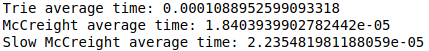

In [24]:
text = "abbbabd"
time_eval(Trie, [text], True, "Trie",count=50)
time_eval(SuffixTree, [text], True, "McCreight",count=50)
time_eval(SuffixTree, [text, True], True, "Slow McCreight",count=50)

Trie average time: 0.0001671881601214409
McCreight average time: 4.1813199932221326e-05
Slow McCreight average time: 5.9389859961811454e-05


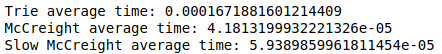

In [25]:
text = "ababcd"
time_eval(Trie, [text], True, "Trie",count=50)
time_eval(SuffixTree, [text], True, "McCreight",count=50)
time_eval(SuffixTree, [text, True], True, "Slow McCreight",count=50)

Trie average time: 0.00018004536017542704
McCreight average time: 2.4469860072713345e-05
Slow McCreight average time: 3.064488002564758e-05


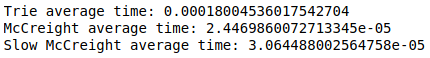

In [18]:
text = "abcbccd"
time_eval(Trie, [text], True, "Trie",count=50)
time_eval(SuffixTree, [text], True, "McCreight",count=50)
time_eval(SuffixTree, [text, True], True, "Slow McCreight",count=50)

Trie average time: 0.0001747623601113446
McCreight average time: 2.3876420164015145e-05
Slow McCreight average time: 3.246553998906165e-05


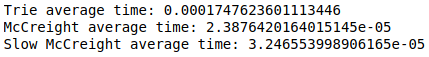

In [11]:
with open('1997_714.txt', 'r') as file:
    text = file.read()
    text = text[:2000]
    text += '\0'
    time_eval(Trie, [text], True, "Trie",count=1)
    time_eval(SuffixTree, [text], True, "McCreight",count=1)
    time_eval(SuffixTree, [text, True], True, "Slow McCreight",count=1)

Trie average time: 7.777111999996123
McCreight average time: 0.01380698500724975
Slow McCreight average time: 0.023901440988993272


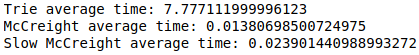